# Import Libraries

In [1]:
import os



In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.config.list_physical_devices('GPU')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=2048)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


2025-07-13 16:11:55.644371: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-13 16:11:56.100176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752394316.290822   42048 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752394316.341695   42048 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752394316.730592   42048 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1752394320.949765   42048 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2048 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


# Exploratory Data Analysis

In [3]:
ROOT = "../../datasets/"
SEED = 88
IMG_SIZE = (224, 224)    # load at original size first
BATCH_SIZE = 128
LABEL_MODE = "categorical" # one‑hot labels straight away
AUTOTUNE = tf.data.AUTOTUNE

classes=["broccoli", "cauliflower", "unknown"]
splits=["test", "train", "validate"]

def load_split(split):
    dataset=tf.keras.preprocessing.image_dataset_from_directory(ROOT+split,
        seed        = SEED,
        image_size  = IMG_SIZE,
        batch_size  = BATCH_SIZE,
        label_mode  = LABEL_MODE)
    return dataset

train_ds_pre = load_split("train")
val_ds_pre = load_split("validate")
test_ds_pre = load_split("test")
train_ds_pre=train_ds_pre.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_pre=val_ds_pre.cache().prefetch(buffer_size=AUTOTUNE)

Found 9856 files belonging to 3 classes.
Found 2505 files belonging to 3 classes.
Found 2502 files belonging to 3 classes.


,broccoli,cauliflower,unknown,splits total
test,1090,1068,344,2502
train,3949,3758,2149,9856
validate,1097,1064,344,2505
img total,6136,5890,2837,14863


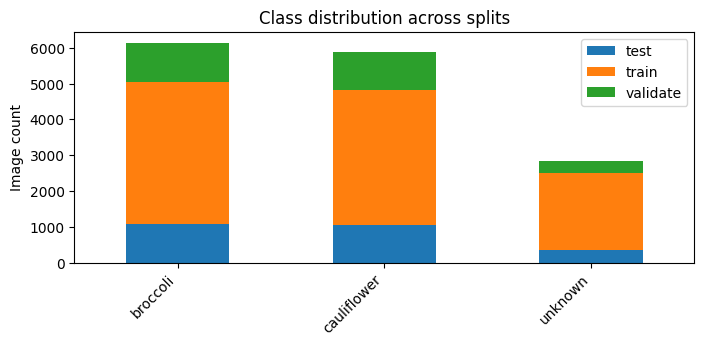

In [4]:
def count_images(split):
    return {cls: len(os.listdir(f"{ROOT}{split}/{cls}/"))
            for cls in classes}

df_counts = pd.DataFrame({s: count_images(s) for s in splits})

table_df = df_counts.T
table_df["splits total"] = table_df.sum(1)
table_df.loc["img total"] = table_df.sum(0)

display(table_df)  # Jupyter table

ax = df_counts.plot.bar(stacked=True, figsize=(8,3))
ax.set_title("Class distribution across splits")
ax.set_ylabel("Image count")
plt.xticks(rotation=45, ha="right")
plt.show()

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS

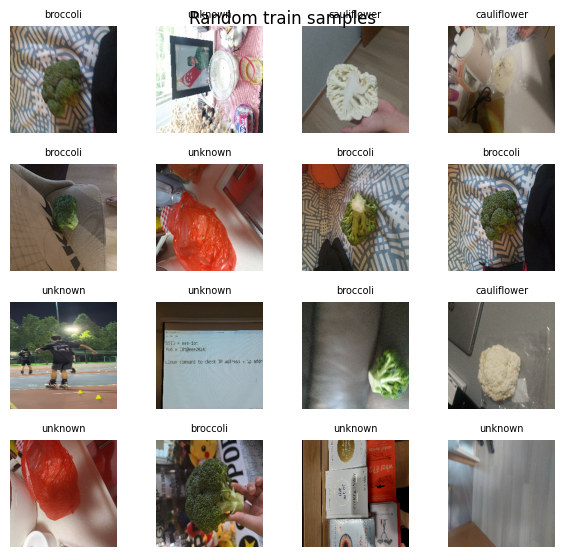

In [5]:
plt.figure(figsize=(6,6))
for images, labels in train_ds_pre.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")
plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Data Preprocessing

In [6]:
TARGET_SIZE = 100

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(TARGET_SIZE, TARGET_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom((0.3), 0.3),
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds

train_ds = prepare(train_ds_pre, shuffle=True, augment=True)
val_ds = prepare(val_ds_pre)
test_ds = prepare(test_ds_pre)

2025-07-13 16:12:46.969580: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 15361536 bytes after encountering the first element of size 15361536 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-07-13 16:12:47.108948: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


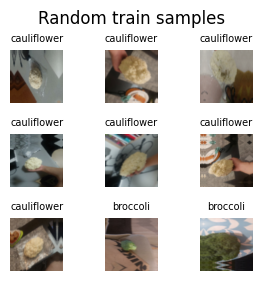

In [7]:
plt.figure(figsize=(3,3))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")

plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Model building

In [8]:
num_classes = 3

model = keras.Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation="relu",
                 input_shape=(TARGET_SIZE, TARGET_SIZE,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(128, (3, 3), padding='same', activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Optimizer = optimizers.Adam(0.001)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Optimizer,
              metrics=['accuracy'])


/home/me/anaconda3/envs/HELP/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,179,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,466,915 (5.60 MB)

 Trainable params: 1,466,915 (5.60 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [10]:
history = model.fit(
    train_ds,
    epochs=20,
    verbose=1,
    validation_data = val_ds,
)

score = model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


model.save_weights('model.weights.h5')
tf.keras.models.save_model(model,'model.h5')

Epoch 1/20


I0000 00:00:1752394377.445677   42522 service.cc:152] XLA service 0x7d143c002f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752394377.445692   42522 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 SUPER, Compute Capability 7.5
2025-07-13 16:12:57.490697: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752394377.694183   42522 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-13 16:12:58.315805: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.18 = (f32[128,32,100,100]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,3,100,100]{3,2,1,0} %bitcast.3285, f32[32,3,3,3]{3,2,1,0} %bitcast.3292, f32[32]{0} %bitcast.3928), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_cal

 1/77 ━━━━━━━━━━━━━━━━━━━━ 16:42 13s/step - accuracy: 0.3203 - loss: 1.0985

I0000 00:00:1752394389.007890   42522 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.4955 - loss: 0.9721

2025-07-13 16:13:21.363168: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.18 = (f32[128,32,100,100]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,3,100,100]{3,2,1,0} %bitcast.612, f32[32,3,3,3]{3,2,1,0} %bitcast.619, f32[32]{0} %bitcast.621), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_2_1/conv2d_1/convolution" source_file="/home/me/anaconda3/envs/HELP/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-13 16:13:21.713481: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Om

77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 257ms/step - accuracy: 0.4970 - loss: 0.9700 - val_accuracy: 0.7669 - val_loss: 0.6305
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - accuracy: 0.8581 - loss: 0.3816 - val_accuracy: 0.8806 - val_loss: 0.3010
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - accuracy: 0.8939 - loss: 0.3081 - val_accuracy: 0.9393 - val_loss: 0.1900
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 164ms/step - accuracy: 0.9597 - loss: 0.1284 - val_accuracy: 0.9393 - val_loss: 0.1798
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - accuracy: 0.9589 - loss: 0.1220 - val_accuracy: 0.8954 - val_loss: 0.2759
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - accuracy: 0.9464 - loss: 0.1643 - val_accuracy: 0.9677 - val_loss: 0.1055
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - accuracy: 0.9704 - loss: 0.0866 - val_accuracy: 0.9329 - val_loss: 0.1902
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 165ms/step - accuracy: 0.9660 - loss: 0.0973 - val_accuracy: 0.812

Invalid SOS parameters for sequential JPEG
2025-07-13 16:17:48.430591: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.18 = (f32[70,32,100,100]{3,2,1,0}, u8[0]{0}) custom-call(f32[70,3,100,100]{3,2,1,0} %bitcast.612, f32[32,3,3,3]{3,2,1,0} %bitcast.619, f32[32]{0} %bitcast.621), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_2_1/conv2d_1/convolution" source_file="/home/me/anaconda3/envs/HELP/lib/python3.10/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-13 16:17:48.703907: I external/local_xla/xla/service/gpu/au

Test loss: 0.07924051582813263
Test accuracy: 0.9720223546028137


# Model Evalutation

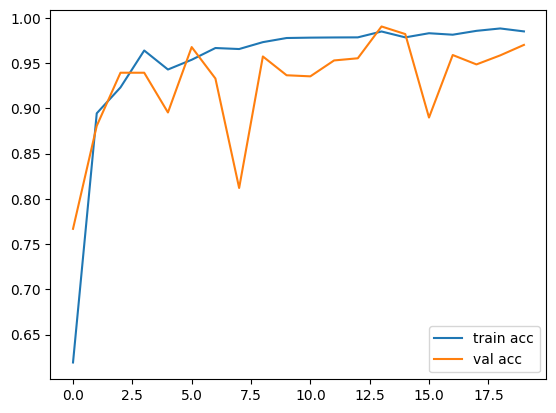

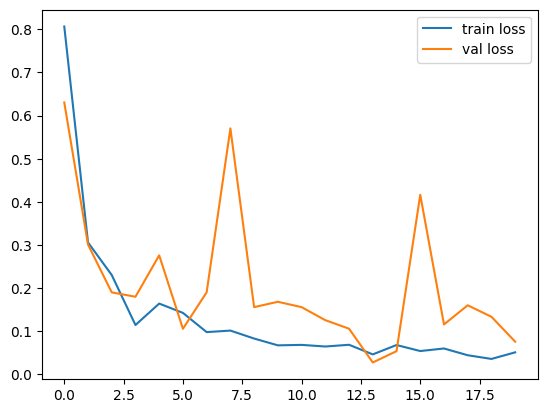

In [11]:
pd.DataFrame(history.history).to_csv("hist.csv", index=False)

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()